In [1]:
using Pkg
Pkg.activate("/media/mat/HDD/AdaptiveTransportMap/")

 Activating environment at `/media/mat/HDD/AdaptiveTransportMap/Project.toml`


In [63]:
using Revise
using LinearAlgebra
using AdaptiveTransportMap
using Statistics
using LinearMaps
using IterativeSolvers
using BenchmarkTools
using LoopVectorization

using LinearMaps
using IterativeSolvers
using ForwardDiff
using ForwardDiff: GradientConfig, Chunk, gradient!

In [9]:
using Plots
default(tickfont = font("CMU Serif", 9), 
        titlefont = font("CMU Serif", 14), 
        guidefont = font("CMU Serif", 12),
        legendfont = font("CMU Serif", 10),
        grid = false)
pyplot()

using LaTeXStrings
PyPlot.rc("font", family = "CMU Serif")
PyPlot.matplotlib[:rc]("mathtext",fontset="cm")        #computer modern font 
PyPlot.matplotlib[:rc]("font",family="serif",size=12)

In [145]:
x1 = -2.0:0.01:2.0
x2 = -2.0:0.01:2.0

h(x, y) = [x; y^2]
# plot(x1, x2, h.(x1, x2))

h (generic function with 2 methods)

In [146]:
ForwardDiff.jacobian(h, [2.0; -1.0])

2×2 Array{Float64,2}:
  1.0   0.0
 -0.0  -2.0

In [ ]:
### Nonlinear case

In [140]:
Nx = 3
Ny = 4 
Ne = 200
X = randn(Nx, Ne)
f(x) = [x[1]; x[2]*x[3]; x[2]^2; x[2]*x[1]]


function mapsqrtCx!(Ny, Ne, vout, vin)
#     @show 1.0
    fill!(vout, 0.0)
    
    @inbounds for j=1:Ne
        # chunk of dimension Ny
        vj = view(vin, (j-1)*Ny+1:j*Ny)
        # A will be the Jacobian of the function f evaluated at x^i
        vout += 
        mul!(vout, A', vj, 1.0, 1.0)
    end
    vout .*= 1/sqrt(Ne)
end

function mapsqrtCxtranspose!(Ny, Ne, vout, vin)
#     @show 2.0
    fill!(vout, 0.0)

    @inbounds for j=1:Ne
        # chunk of dimension Ny
        vj = view(vout, (j-1)*Ny+1:j*Ny)
        # A will be the Jacobian of the function f evaluated at x^i
        mul!(vj, A, vin, 1.0, 1.0)
    end
    vout .*= 1/sqrt(Ne)
end

function mapsqrtCy!(Nx, Ne, vout, vin)
    @show 3.0
    fill!(vout, 0.0)
    
    @inbounds for j=1:Ne
        # chunk of dimension Nx
        vj = view(vin, (j-1)*Nx+1:j*Nx)
        # A will be the Jacobian of the function f evaluated at x^i
        mul!(vout, A, vj, 1.0, 1.0)
    end
    vout .*= 1/sqrt(Ne)
end

function mapsqrtCytranspose!(Nx, Ne, vout, vin)
    @show 4.0    
    fill!(vout, 0.0)

    @inbounds for j=1:Ne
        # chunk of dimension Nx
        vj = view(vout, (j-1)*Nx+1:j*Nx)
        # A will be the Jacobian of the function f evaluated at x^i
        mul!(vj, A', vin, 1.0, 1.0)
    end
    vout .*= 1/sqrt(Ne)
end

sqrtCx = LinearMap((vout, vin) -> mapsqrtCx!(Ny, Ne, vout, vin), 
                   (vout, vin) -> mapsqrtCxtranspose!(Ny, Ne, vout, vin), 
                   Nx, Ny*Ne; ismutating = true)

sqrtCy = LinearMap((vout, vin) -> mapsqrtCy!(Nx, Ne, vout, vin), 
                   (vout, vin) -> mapsqrtCytranspose!(Nx, Ne, vout, vin), 
                   Ny, Nx*Ne; ismutating = true)

cache = ones(Ny, Ne)
@time 1/sqrt(Ne)*sum(A'*cache;dims = 2)

v = ones(Ny*Ne);
@time sqrtCx*v

@show norm(1/sqrt(Ne)*sum(A'*ones(Ny, Ne);dims = 2)-sqrtCx*v)

4

In [138]:
f(x0)

4-element Array{Float64,1}:
 1.0
 6.0
 4.0
 2.0

In [139]:
cfg = GradientConfig(f, zeros(Nx))

GradientConfig{ForwardDiff.Tag{typeof(f),Float64},Float64,3,Array{ForwardDiff.Dual{ForwardDiff.Tag{typeof(f),Float64},Float64,3},1}}((Partials(1.0, 0.0, 0.0), Partials(0.0, 1.0, 0.0), Partials(0.0, 0.0, 1.0)), ForwardDiff.Dual{ForwardDiff.Tag{typeof(f),Float64},Float64,3}[Dual{ForwardDiff.Tag{typeof(f),Float64}}(0.0,5.0e-324,6.8992526675028e-310,5.0e-324), Dual{ForwardDiff.Tag{typeof(f),Float64}}(5.0e-324,6.89925266750285e-310,2.0e-323,1.5e-323), Dual{ForwardDiff.Tag{typeof(f),Float64}}(6.8992526675155e-310,2.5e-323,1.5e-323,6.8992563359395e-310)])

In [133]:
ForwardDiff.Dual{Float64}(x0, a)

LoadError: [91mArgumentError: Cannot create a dual over scalar type Array{Float64,1}. If the type behaves as a scalar, define FowardDiff.can_dual.[39m

In [136]:
ForwardDiff.seed!(cfg.duals, x0)

3-element Array{ForwardDiff.Dual{ForwardDiff.Tag{typeof(f),Float64},Float64,3},1}:
 Dual{ForwardDiff.Tag{typeof(f),Float64}}(1.0,0.0,0.0,0.0)
 Dual{ForwardDiff.Tag{typeof(f),Float64}}(2.0,0.0,0.0,0.0)
 Dual{ForwardDiff.Tag{typeof(f),Float64}}(3.0,0.0,0.0,0.0)

In [127]:
cfg.duals

3-element Array{ForwardDiff.Dual{ForwardDiff.Tag{typeof(f),Float64},Float64,3},1}:
 Dual{ForwardDiff.Tag{typeof(f),Float64}}(6.89930511139483e-310,6.89930511139483e-310,6.8992298948401e-310,6.8992298948417e-310)
 Dual{ForwardDiff.Tag{typeof(f),Float64}}(6.8992298950077e-310,6.8992316992991e-310,6.89922989484644e-310,6.89922989484803e-310)
 Dual{ForwardDiff.Tag{typeof(f),Float64}}(6.8992298948496e-310,6.89922989485277e-310,6.89922989485435e-310,6.8992316993813e-310)

In [129]:
cfg.seeds[1]

3-element ForwardDiff.Partials{3,Float64}:
 1.0
 0.0
 0.0

In [130]:
ForwardDiff.Partials

ForwardDiff.Partials

In [120]:
ForwardDiff.construct_seeds(ForwardDiff.Partials{Nx,Float64})

(Partials(1.0, 0.0, 0.0), Partials(0.0, 1.0, 0.0), Partials(0.0, 0.0, 1.0))

In [91]:
ForwardDiff.Dual(x0, a)

LoadError: [91mArgumentError: Cannot create a dual over scalar type Array{Float64,1}. If the type behaves as a scalar, define FowardDiff.can_dual.[39m

In [102]:
x0 = [1.0; 2.0; 3.0]
a = randn(Nx)
b = randn(Ny)

4-element Array{Float64,1}:
  1.3799146963823623
 -0.15774830363194933
  0.22269759023129562
  1.2893752688650402

In [103]:
Ja = ForwardDiff.derivative(ϵ->f(x0 + ϵ*a), 0.0)
J = ForwardDiff.jacobian(f, x0)
J*a-Ja

4-element Array{Float64,1}:
 -0.11437051683247801
 -1.7388165171713408
 -0.37399497198907544
 -0.32223977666222486

In [104]:
# Evaluate f for a DualVector (x0, a)

4×3 Array{Float64,2}:
 1.0  0.0  0.0
 0.0  3.0  2.0
 0.0  4.0  0.0
 2.0  1.0  0.0

In [106]:
@code_lowered ForwardDiff.jacobian(f, x0)

CodeInfo(
1 ─ %1 = ForwardDiff.JacobianConfig(f, x)
│   %2 = (#self#)(f, x, %1)
└──      return %2
)

In [ ]:
# Compute J^Tv

In [123]:
Jtb = ForwardDiff.gradient(x->dot(f(x), b), x0)

3-element Array{Float64,1}:
  3.9586652341124426
  1.7069207188943747
 -0.31549660726389867

In [124]:
J'*b

3-element Array{Float64,1}:
  3.9586652341124426
  1.7069207188943747
 -0.31549660726389867

In [125]:
J'*b-Jtb

3-element Array{Float64,1}:
 0.0
 0.0
 0.0

In [128]:
Nx = 100
Ny = 10
maxrank = min(Nx, Ny)

A = rdnortho(Ny)[:,1:maxrank]*Diagonal(map(i->100/(i^3) + 0.01, 1:maxrank))*rdnortho(Nx)[:,1:maxrank]'
# A = randn(Ny, Nx)

svdA = deepcopy(svd(A))
UA = svdA.U
VA = Matrix(svdA.Vt')
ΛA = svdA.S
@show norm(A-UA*Diagonal(ΛA)*VA')

Ne = 200
X = randn(Nx, Ne)

function mapsqrtCx!(Ny, Ne, vout, vin)
#     @show 1.0
    fill!(vout, 0.0)
    
    @inbounds for j=1:Ne
        # chunk of dimension Ny
        vj = view(vin, (j-1)*Ny+1:j*Ny)
        # A will be the Jacobian of the function f evaluated at x^i
        mul!(vout, A', vj, 1.0, 1.0)
    end
    vout .*= 1/sqrt(Ne)
end

function mapsqrtCxtranspose!(Ny, Ne, vout, vin)
#     @show 2.0
    fill!(vout, 0.0)

    @inbounds for j=1:Ne
        # chunk of dimension Ny
        vj = view(vout, (j-1)*Ny+1:j*Ny)
        # A will be the Jacobian of the function f evaluated at x^i
        mul!(vj, A, vin, 1.0, 1.0)
    end
    vout .*= 1/sqrt(Ne)
end

function mapsqrtCy!(Nx, Ne, vout, vin)
    @show 3.0
    fill!(vout, 0.0)
    
    @inbounds for j=1:Ne
        # chunk of dimension Nx
        vj = view(vin, (j-1)*Nx+1:j*Nx)
        # A will be the Jacobian of the function f evaluated at x^i
        mul!(vout, A, vj, 1.0, 1.0)
    end
    vout .*= 1/sqrt(Ne)
end

function mapsqrtCytranspose!(Nx, Ne, vout, vin)
    @show 4.0    
    fill!(vout, 0.0)

    @inbounds for j=1:Ne
        # chunk of dimension Nx
        vj = view(vout, (j-1)*Nx+1:j*Nx)
        # A will be the Jacobian of the function f evaluated at x^i
        mul!(vj, A', vin, 1.0, 1.0)
    end
    vout .*= 1/sqrt(Ne)
end

sqrtCx = LinearMap((vout, vin) -> mapsqrtCx!(Ny, Ne, vout, vin), 
                   (vout, vin) -> mapsqrtCxtranspose!(Ny, Ne, vout, vin), 
                   Nx, Ny*Ne; ismutating = true)

sqrtCy = LinearMap((vout, vin) -> mapsqrtCy!(Nx, Ne, vout, vin), 
                   (vout, vin) -> mapsqrtCytranspose!(Nx, Ne, vout, vin), 
                   Ny, Nx*Ne; ismutating = true)

cache = ones(Ny, Ne)
@time 1/sqrt(Ne)*sum(A'*cache;dims = 2)

v = ones(Ny*Ne);
@time sqrtCx*v

@show norm(1/sqrt(Ne)*sum(A'*ones(Ny, Ne);dims = 2)-sqrtCx*v)

norm(A - UA * Diagonal(ΛA) * VA') = 8.343011905140935e-14
  0.000063 seconds (11 allocations: 158.203 KiB)
  0.040034 seconds (66.19 k allocations: 3.523 MiB)
norm((1 / sqrt(Ne)) * sum(A' * ones(Ny, Ne); dims = 2) - sqrtCx * v) = 5.944538435082983e-12


5.944538435082983e-12

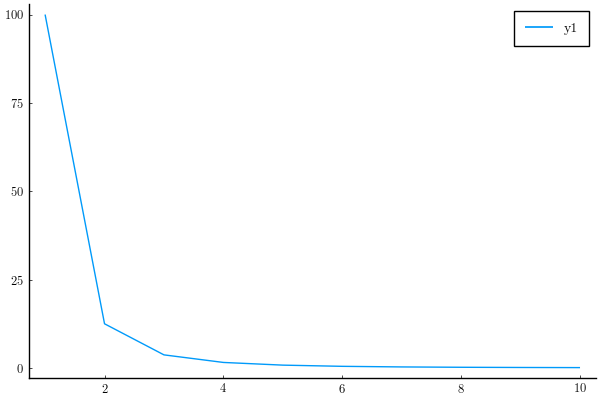

In [115]:
plot(ΛA)

In [116]:
Aaug = hcat([A, A, A]...)

Aaug' - vcat([A', A', A']...)
Aaug'[1:Nx,1:Ny] - A';

In [110]:
?psvd

search: psvd psvdvals psvdfact PRESERVE_DIRECT PartialSVD PRESERVE_TIERED



No documentation found.

`LowRankApprox.psvd` is a `Function`.

```
# 1 method for generic function "psvd":
[1] psvd(A, args...; kwargs...) in LowRankApprox at /home/mat/.julia/packages/LowRankApprox/2wpw4/src/psvd.jl:296
```


In [126]:
?psvdfact

search: psvdfact



No documentation found.

`LowRankApprox.psvdfact` is a `Function`.

```
# 3 methods for generic function "psvdfact":
[1] psvdfact(A::Union{AbstractArray{T,2}, AbstractLinearOperator{T}}) where T in LowRankApprox at /home/mat/.julia/packages/LowRankApprox/2wpw4/src/psvd.jl:238
[2] psvdfact(A::Union{AbstractArray{T,2}, AbstractLinearOperator{T}}, opts::LRAOptions; args...) where T in LowRankApprox at /home/mat/.julia/packages/LowRankApprox/2wpw4/src/psvd.jl:238
[3] psvdfact(A, args...; kwargs...) in LowRankApprox at /home/mat/.julia/packages/LowRankApprox/2wpw4/src/psvd.jl:293
```


In [118]:
@time SCx = psvdfact(sqrtCx, rank = 5)

1.0 = 1.0
1.0 = 1.0
1.0 = 1.0
1.0 = 1.0
1.0 = 1.0
1.0 = 1.0
1.0 = 1.0
1.0 = 1.0
1.0 = 1.0
1.0 = 1.0
1.0 = 1.0
1.0 = 1.0
1.0 = 1.0
1.0 = 1.0
1.0 = 1.0
1.0 = 1.0
1.0 = 1.0
1.0 = 1.0
1.0 = 1.0
1.0 = 1.0
1.0 = 1.0
1.0 = 1.0
1.0 = 1.0
1.0 = 1.0
1.0 = 1.0
1.0 = 1.0
1.0 = 1.0
1.0 = 1.0
1.0 = 1.0
1.0 = 1.0
1.0 = 1.0
1.0 = 1.0
1.0 = 1.0
1.0 = 1.0
1.0 = 1.0
1.0 = 1.0
1.0 = 1.0
1.0 = 1.0
1.0 = 1.0
1.0 = 1.0
2.0 = 2.0
2.0 = 2.0
2.0 = 2.0
2.0 = 2.0
2.0 = 2.0
  0.009484 seconds (61.56 k allocations: 3.779 MiB)


PartialSVD{Float64,Float64}([-0.21489659982921128 0.040541436609761096 … 0.0500885401765511 -0.015908041671289255; 0.11095488659978824 0.0456885726907314 … 0.029735323760836534 0.12218186283870584; … ; 0.12749467400217923 0.07629480490889445 … 0.031866426254116564 0.03225920792288324; 0.019786385277386482 -0.027071220646916982 … 0.04155814486008805 -0.059660239706516446], [99.90434660654964, 12.527372138003582, 3.6988862288465705, 1.5221622818833893, 0.7695938071550588], [0.036269919052181354 -0.009379898933995361 … -0.007707998513275308 0.01748544877819928; 0.029241584666730918 -0.012069525579371021 … -0.0021606011978076954 -0.040589627178194795; … ; 0.008267459069145396 -0.03613210015381858 … 0.007238450726223891 -0.004886958658709389; -0.009208210375603654 0.00626866992683809 … 0.028194111152206023 -0.034025871272638654])

In [129]:
@btime SCx, errorCx  = svdl(sqrtCx; nsv = 4, vecs = :left);

  1.890 ms (10244 allocations: 2.29 MiB)


In [133]:
@btime eigen(A*A')

  20.560 μs (13 allocations: 7.77 KiB)


Eigen{Float64,Float64,Array{Float64,2},Array{Float64,1}}
values:
10-element Array{Float64,1}:
     0.012100000000455536
     0.02166024845648693
     0.04215322265630016
     0.09092950131357137
     0.22369396433505828
     0.6561000000001262
     2.4727562499999007
    13.791595198902725
   156.50009999999978
 10002.00009999999
vectors:
10×10 Array{Float64,2}:
  0.28865     0.221769   -0.0974508   …   0.571901   -0.0854113  -0.0457777
 -0.210096    0.10485     0.577876       -0.310206   -0.320828    0.00606528
  0.404081    0.39284     0.11824        -0.0232227   0.527375   -0.111582
 -0.397764    0.0179987   0.517429        0.494155    0.0439407   0.170584
 -0.00631    -0.237463   -0.366342        0.209213   -0.526587   -0.172667
  0.434575   -0.19795     0.399232    …   0.233931   -0.106243   -0.330327
 -0.280951    0.503492   -0.221669        0.283454   -0.0219059   0.346799
  0.474244    0.242799    0.159942       -0.0214226  -0.492379    0.418611
  0.0595651   0.409411   -0.0805

In [130]:
@time SCx, errorCx  = svdl(sqrtCx; nsv = 4, vecs = :left);
@time SCy, errorCy  = svdl(sqrtCy; nsv = 4, vecs = :left);

  0.002500 seconds (10.26 k allocations: 2.383 MiB)
3.0 = 3.0
4.0 = 4.0
3.0 = 3.0
4.0 = 4.0
3.0 = 3.0
4.0 = 4.0
3.0 = 3.0
4.0 = 4.0
3.0 = 3.0
4.0 = 4.0
3.0 = 3.0
4.0 = 4.0
3.0 = 3.0
4.0 = 4.0
3.0 = 3.0
4.0 = 4.0
3.0 = 3.0
4.0 = 4.0
4.0 = 4.0
3.0 = 3.0
4.0 = 4.0
3.0 = 3.0
4.0 = 4.0
3.0 = 3.0
4.0 = 4.0
  0.662743 seconds (2.16 M allocations: 127.712 MiB, 1.96% gc time)


In [98]:
# Use the characterization of the SVD to compute a sign consistent singular vectors V
Vflipped = zeros(Nx, 5)

for i=1:5
    ui = SCy.U[:,i]
    Vflipped[:,i] .=  sqrtCx*repeat(ui, Ne)/(√(Ne)*SCx.S[i])
    @show norm(sqrtCx*repeat(ui, Ne)/(√(Ne)*SCx.S[i])-SCx.U[:,i])
end

1.0 = 1.0
1.0 = 1.0
norm((sqrtCx * repeat(ui, Ne)) / (√Ne * SCx.S[i]) - SCx.U[:, i]) = 1.9602995946748376
1.0 = 1.0
1.0 = 1.0
norm((sqrtCx * repeat(ui, Ne)) / (√Ne * SCx.S[i]) - SCx.U[:, i]) = 2.2350852103806402
1.0 = 1.0
1.0 = 1.0
norm((sqrtCx * repeat(ui, Ne)) / (√Ne * SCx.S[i]) - SCx.U[:, i]) = 1.4700886100400248
1.0 = 1.0
1.0 = 1.0
norm((sqrtCx * repeat(ui, Ne)) / (√Ne * SCx.S[i]) - SCx.U[:, i]) = 1.9179433839316498
1.0 = 1.0
1.0 = 1.0
norm((sqrtCx * repeat(ui, Ne)) / (√Ne * SCx.S[i]) - SCx.U[:, i]) = 4.8321407811875146


In [99]:
UA[:,1:5]*Diagonal(ΛA[1:5])*(VA[:,1:5])'

10×100 Array{Float64,2}:
  4.71934  -1.74471    2.89074  -3.22781  …   5.40098   3.85934  -1.84141
 -3.79206   0.138559  -1.61874   2.09782     -4.28603  -2.6412    1.56416
  7.39327  -1.65567    3.91819  -4.57165      8.12691   5.59735  -2.91946
 -6.38317   1.42739   -3.42785   4.02147     -7.14006  -4.91777   2.53751
  3.29427  -1.47436    2.08403  -2.08408      3.8045    2.49156  -1.50989
  3.00108   0.258591   1.06641  -1.62098  …   3.05451   2.06957  -0.996446
 -5.21653   0.830001  -2.60754   3.34095     -5.54566  -4.09114   1.74611
  5.30818  -1.68312    3.03229  -3.25659      6.10112   3.95241  -2.35003
  8.68308  -2.74846    5.07249  -5.68586      9.89815   6.86442  -3.52214
 -1.4293    0.497095  -0.85369   1.0         -1.63307  -1.19111   0.507568

In [56]:
norm(SCy.U[:,1:5]*Diagonal(SCy.S)*Vflipped'-UA[:,1:5]*Diagonal(ΛA[1:5])*(VA[:,1:5])')

2.2187006034736736e-8

In [293]:
ΛA

10-element Array{Float64,1}:
 7.168320388943877
 6.385227303864496
 5.645280671469176
 4.788366908387402
 4.524817351764382
 4.2439298262305405
 3.642842575265584
 3.097335578359893
 2.6408521844951496
 2.2640992623999643

In [294]:
VA

20×10 Array{Float64,2}:
  0.0801299   -0.239461    0.0512219  …  -0.144675    0.259027    0.0590847
  0.536357    -0.112479   -0.56401       -0.0363053   0.0623915  -0.235716
 -0.0440869   -0.118124   -0.0172561      0.40879    -0.189308    0.0793139
 -0.21828      0.246072   -0.0834668      0.286907    0.111517   -0.0421737
  0.0165515    0.0913264   0.171071       0.138628    0.222504    0.515868
 -0.0821933   -0.333191    0.0894672  …   0.153179   -0.328914   -0.18744
 -0.448108     0.0218479  -0.284957      -0.44656    -0.182259    0.36718
 -0.212235    -0.0467525  -0.0367269      0.149958   -0.482646   -0.0664461
 -0.12395     -0.150087   -0.0371922     -0.0509557  -0.318956   -0.19351
 -0.00845517   0.0275854  -0.312868       0.246525   -0.152187    0.43618
  0.0426937    0.176726   -0.0403377  …   0.174299   -0.103469   -0.0802576
 -0.296621     0.282167    0.218224       0.0313168   0.0827961  -0.368448
 -0.279658    -0.42035    -0.242909       0.377056    0.239358    0.0537749

In [232]:
@time svd(A)

  0.000060 seconds (8 allocations: 11.531 KiB)


SVD{Float64,Float64,Array{Float64,2}}
U factor:
10×10 Array{Float64,2}:
 -0.50436     0.468988    -0.327095   …  -0.058568    0.283128
 -0.0864138  -0.54991     -0.0982356      0.439312    0.380967
 -0.399826   -0.435268    -0.417825      -0.467853    0.0713905
  0.452498    0.141507    -0.247575      -0.0482586   0.594967
 -0.212934   -0.00850176   0.0227263     -0.0281845  -0.290359
  0.161898   -0.327976     0.430423   …  -0.186365    0.164541
 -0.0758274  -0.19966     -0.139723       0.290867   -0.42956
 -0.0601214   0.241651    -0.0675069      0.595077   -0.000350149
  0.219498   -0.226827    -0.538889       0.21655    -0.10455
 -0.494412   -0.104004     0.3837         0.247423    0.329826
singular values:
10-element Array{Float64,1}:
 100.01000000000012
  12.509999999999996
   3.713703703703704
   1.572500000000002
   0.8100000000000005
   0.4729629629629644
   0.3015451895043731
   0.20531249999999995
   0.1471742112482845
   0.11000000000000253
Vt factor:
10×20 Array{Float64,2}